In [6]:
pip install -U --pre segmentation-models

In [7]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

In [8]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/Colab/archive2.zip'

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/liverdata')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


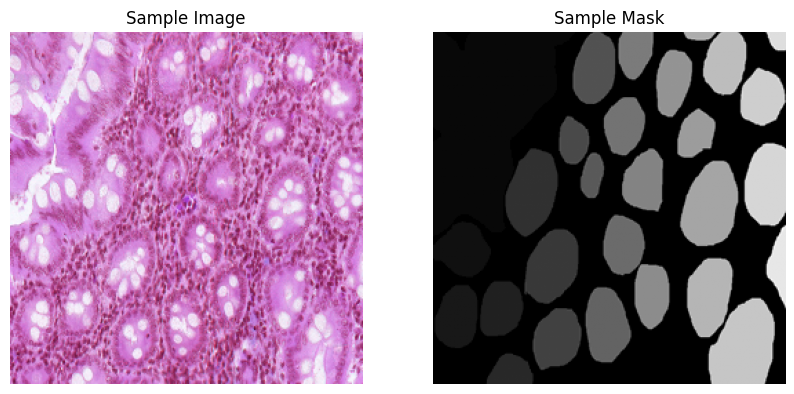

171164896/171164896 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38s/step - accuracy: 0.2490 - loss: 0.7551 - mean_io_u: 1.0000 
Epoch 1: val_loss improved from inf to 1475416.62500, saving model to T1_RES101_Unet_best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 461s 42s/step - accuracy: 0.2600 - loss: 0.7452 - mean_io_u: 1.0000 - val_accuracy: 0.0281 - val_loss: 1475416.6250 - val_mean_io_u: 0.0285
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38s/step - accuracy: 0.4900 - loss: 0.3949 - mean_io_u: 1.0000 
Epoch 2: val_loss did not improve from 1475416.62500
9/9 ━━━━━━━━━━━━━━━━━━━━ 449s 43s/step - accuracy: 0.4897 - loss: 0.3919 - mean_io_u: 1.0000 - val_accuracy: 0.0199 - val_loss: 12787936.0000 - val_mean_io_u: 0.0185
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40s/step - accuracy: 0.4777 - loss: 0.2593 - mean_io_u: 1.0000 
Epoch 3: val_loss improved from 1475416.62500 to 15433.31641, saving model to T1_RES101_Unet_best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 408s 46s/step 

In [5]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU
import segmentation_models as sm  # Make sure this is installed: pip install segmentation-models

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

# Model setup
BACKBONE = 'resnet101'
preprocess_input = sm.get_preprocessing(BACKBONE)

# Dataset path
data_dir = '/content/liverdata/Warwick_QU_Dataset/'
images = []
masks = []

# Load image-mask pairs
for filename in os.listdir(data_dir):
    if filename.endswith('.bmp') and '_anno' not in filename:
        image_path = os.path.join(data_dir, filename)
        mask_name = filename.replace('.bmp', '_anno.bmp')
        mask_path = os.path.join(data_dir, mask_name)


        if os.path.exists(mask_path):
            # Load image (RGB)
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if img is not None:
                img_resized = cv2.resize(img, (256, 256))
                image = img_to_array(img_resized) / 255.0
                images.append(image)

            # Load mask (Grayscale → 1 channel)
            with Image.open(mask_path) as msk:
                msk_resized = msk.resize((256, 256), Image.LANCZOS)
                msk_gray = msk_resized.convert('L')  # Convert to grayscale
                mask = img_to_array(msk_gray) / 255.0
                mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
                masks.append(mask)

# Convert to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Display a sample image and mask
if len(images) > 0:
    sample_index = min(47, len(images) - 1)
    sample_image = images[sample_index]
    sample_mask = masks[sample_index]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image.astype('float32'))
    plt.title('Sample Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(sample_mask.squeeze(), cmap='gray')
    plt.title('Sample Mask')
    plt.axis('off')
    plt.show()
else:
    print("No valid image/mask pairs found.")
    exit()

# Split and preprocess
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
x_train = preprocess_input(train_images)
x_val = preprocess_input(val_images)

# Define and compile model
model = sm.Unet(BACKBONE, classes=1, activation='sigmoid', encoder_weights='imagenet')
model.compile('Adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2), 'accuracy'])

# Callbacks
tensorboard_callback = TensorBoard(log_dir='t1_Res101_Unet_logs')
model_checkpoint_callback = ModelCheckpoint('T1_RES101_Unet_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train model
history = model.fit(
    x=train_images,
    y=train_masks,
    batch_size=16,
    epochs=100,
    validation_data=(val_images, val_masks),
    callbacks=[tensorboard_callback, model_checkpoint_callback]
)


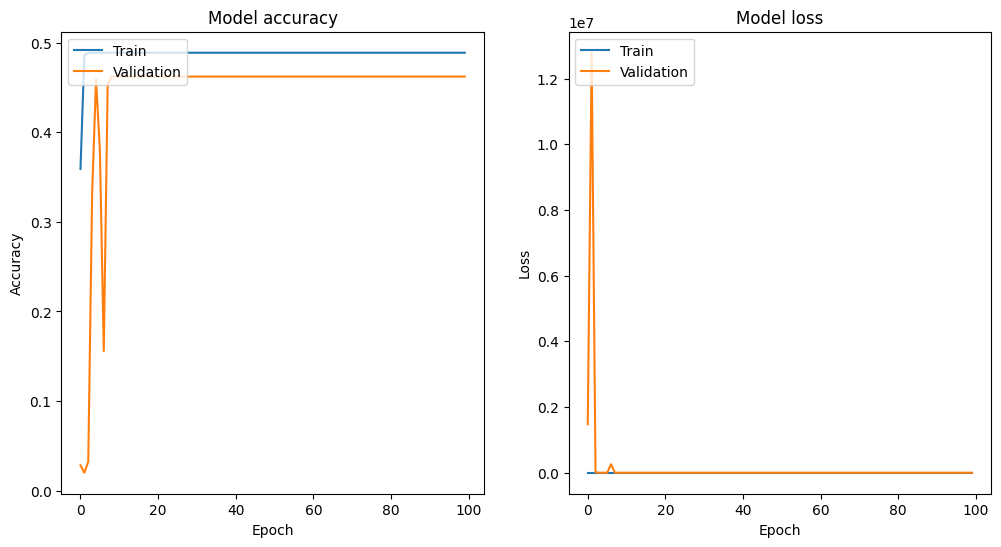

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction range: 0.0 to 3.707385e-35


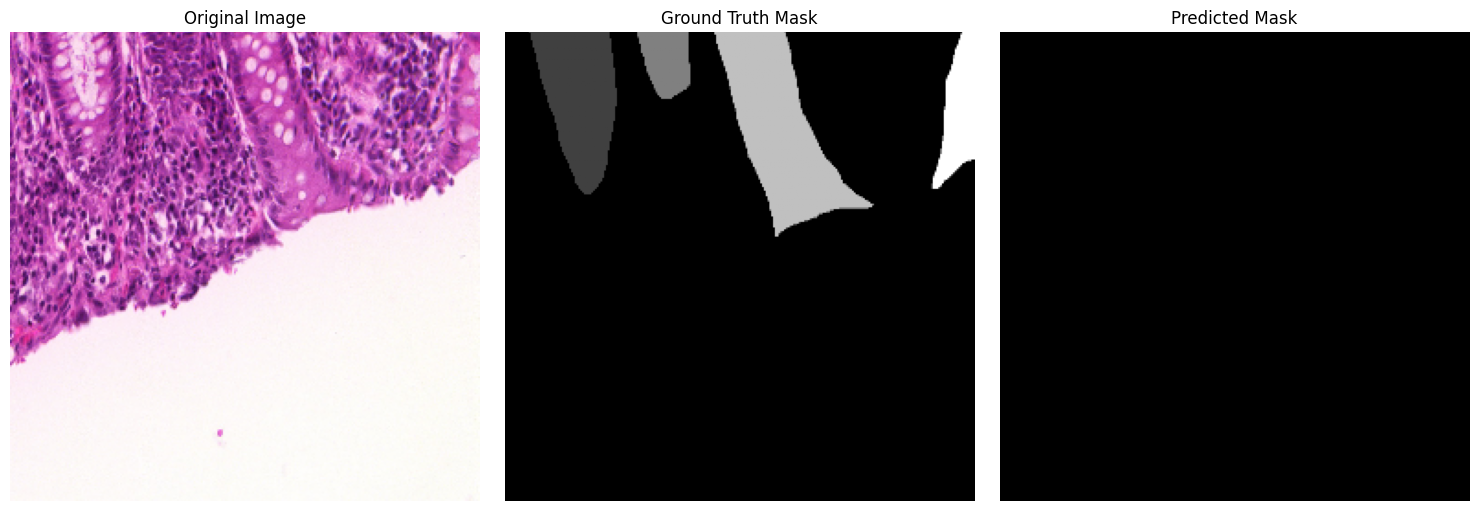

In [20]:
import cv2
import numpy as np
import segmentation_models as sm
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import os

# Load the pre-trained model
BACKBONE = 'resnet101'
preprocess_input = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.load_weights('/content/T1_RES101_Unet_best_model.keras')

# Define preprocessing function
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_resized = cv2.resize(img, (256, 256))
    image = img_to_array(img_resized)
    image = preprocess_input(image)
    return image

# Set image and mask paths
test_image_path = '/content/liverdata/Warwick_QU_Dataset/testA_11.bmp'
test_mask_path = test_image_path.replace('.bmp', '_anno.bmp')

# Preprocess image
test_image = preprocess_image(test_image_path)
test_image = np.expand_dims(test_image, axis=0)  # Shape: (1, 256, 256, 3)

# Predict
predictions = model.predict(test_image)
print("Prediction range:", np.min(predictions), "to", np.max(predictions))

# Apply threshold
predictions = (predictions > 0.3).astype(np.uint8)

# Load and preprocess mask
if not os.path.exists(test_mask_path):
    raise FileNotFoundError(f"Mask not found at {test_mask_path}")

test_mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
test_mask = cv2.resize(test_mask, (256, 256)) / 255.0

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
original_img = cv2.imread(test_image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (256, 256))
axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Ground truth mask
axes[1].imshow(test_mask, cmap='gray')
axes[1].set_title('Ground Truth Mask')
axes[1].axis('off')

# Predicted mask
axes[2].imshow(predictions[0, :, :, 0], cmap='gray')
axes[2].set_title('Predicted Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()
